# Classifying Flowers using Transfer Learning in Keras

Assignment 2 - Convolutional Neural Nets and Transfer Learning

By Gordon Chan (qq525548)


This notebook is based on Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow by Aurélien Géron.

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
random.seed(42)


C:\Users\kaizi\anaconda3\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.16.1


In [3]:
data_dir = 'C:\\Users\\kaizi\\Desktop\\jupyter\\DeepLearning\\flower_photos\\flower_photos'

In [4]:
os.listdir(data_dir)

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

In [5]:
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

## Loading data

In [6]:
from sklearn.model_selection import train_test_split

# Get the list of classes (folders)
classes = ['tulips', 'roses', 'sunflowers', 'dandelion', 'daisy']

# Initialize the lists to store the images and labels
images = []
labels = []

# Desired dimensions
target_height = 224
target_width = 224

# Loop through each class folder
for class_ in classes:
    # Get the list of images in the current class folder
    image_paths = tf.io.gfile.glob(f'{data_dir}/{class_}/*.jpg')

    # Loop through each image
    for image_path in image_paths:
        # Read the image
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)
        
        # Add the image and label to the lists
        images.append(image)
        labels.append(class_)

# Split the data into training and testing sets (80% for training and 20% for testing)
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Print the shapes of the training and testing sets
print(f'Training images shape: {len(train_images)}')
print(f'Testing images shape: {len(test_images)}')

Training images shape: 2936
Testing images shape: 734


In [7]:
# split off 15% of training set as validation set
validation_images, remaining_images, validation_labels, remaining_labels = train_test_split(
    train_images, train_labels, test_size=0.85, random_state=42, stratify=train_labels
)

# Update the training data to be the remaining images and labels
train_images = remaining_images
train_labels = remaining_labels

In [8]:
print(f'Training images shape: {len(train_images)}')
print(f'Validation images shape: {len(validation_images)}')
print(f'Testing images shape: {len(test_images)}')

Training images shape: 2496
Validation images shape: 440
Testing images shape: 734


In [9]:
def show_images(images, num, labels):
    plt.figure(figsize=(10, 10))
    for i in range(num):
      plt.subplot(3, 3, i+1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      plt.imshow(images[i], cmap=plt.cm.binary)
      plt.xlabel(labels[i])
    plt.show()

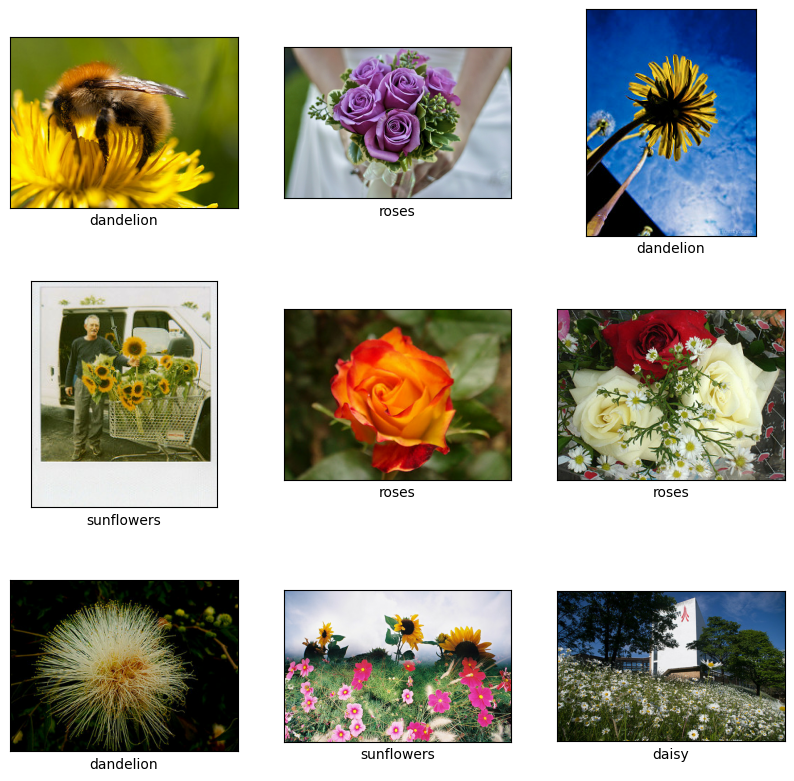

In [10]:
show_images(train_images, 9, train_labels)

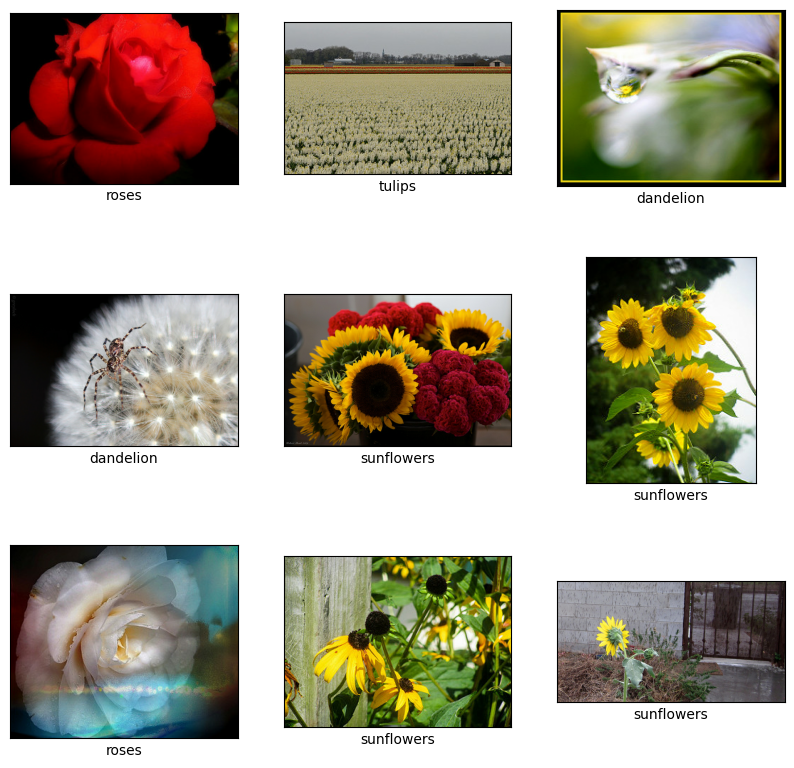

In [11]:
show_images(validation_images, 9, validation_labels)

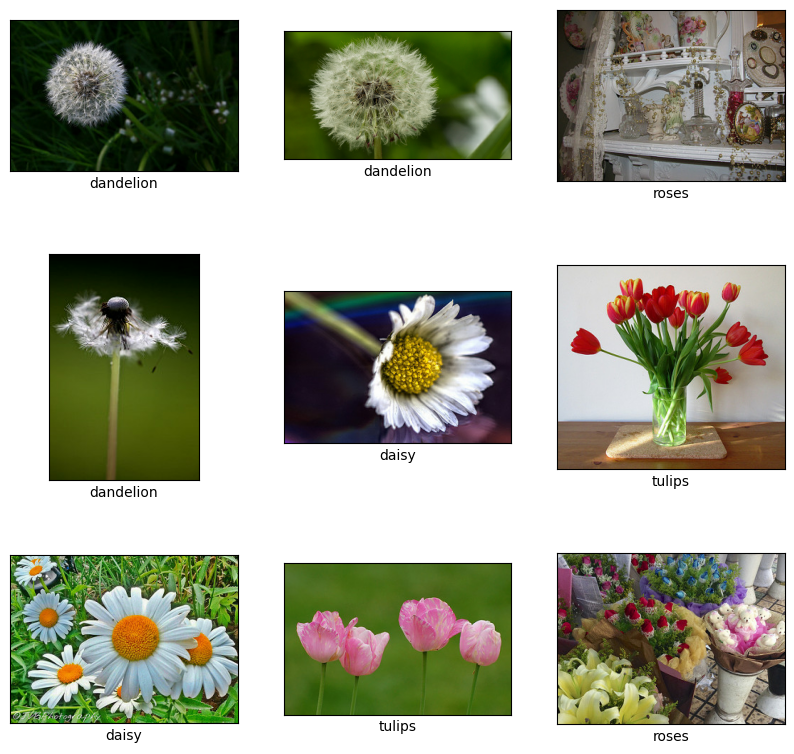

In [12]:
show_images(test_images, 9, test_labels)

## Preprocessing Images

In [13]:
def string_to_tensor(str):
   index = class_names.index(str)
   return tf.convert_to_tensor(index, dtype=tf.int64)

In [14]:
from keras.applications.vgg16 import preprocess_input

preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])

In [15]:
def transform_images(images, labels):
  labels = [string_to_tensor(s) for s in labels]
  image_set = [preprocess(x) for x in images]
  dataset = tf.data.Dataset.from_tensor_slices((image_set, labels))
  return dataset

In [16]:
def show_dataset_images(dataset):
  plt.figure(figsize=(12, 10))
  index = 0
  for image, label in dataset.take(9):
      index += 1
      plt.subplot(3, 3, index)
      
      # Reverse preprocessing for visualization
      image = (image + 1) * 127.5  # Xception preprocessing: (image / 127.5) - 1
      image = np.clip(image, 0, 255).astype(np.uint8)
      
      plt.imshow(image)
      plt.title(f"Label: {class_names[label]}")
      plt.axis("off")

  plt.show()

In [17]:
train_dataset = transform_images(train_images, train_labels)

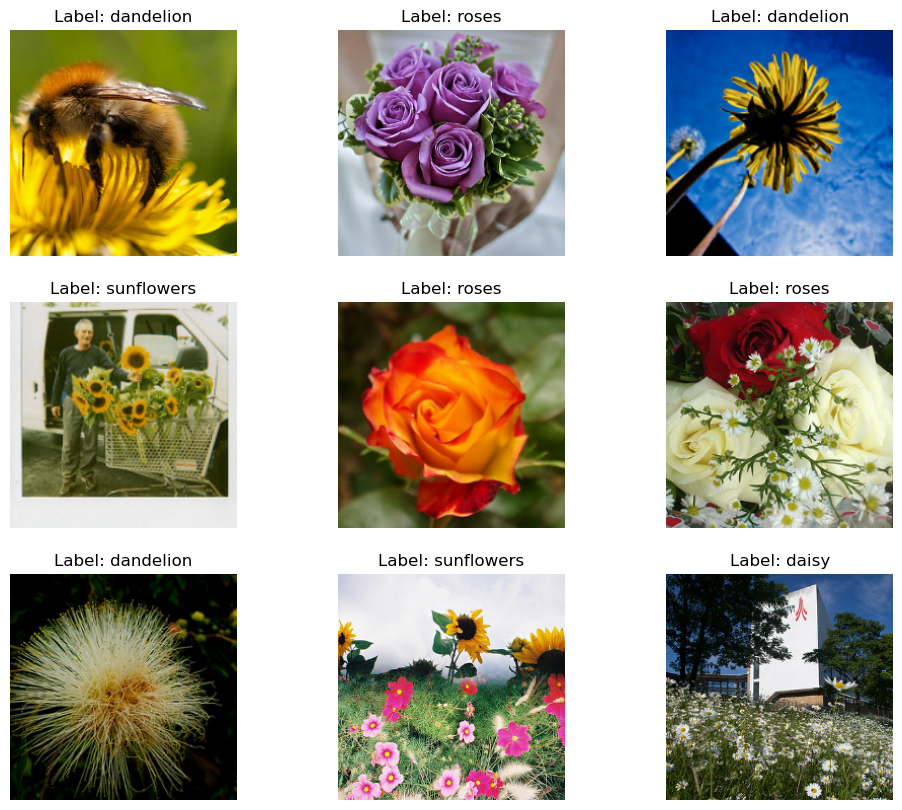

In [18]:
show_dataset_images(train_dataset)

In [19]:
validation_dataset = transform_images(validation_images, validation_labels)

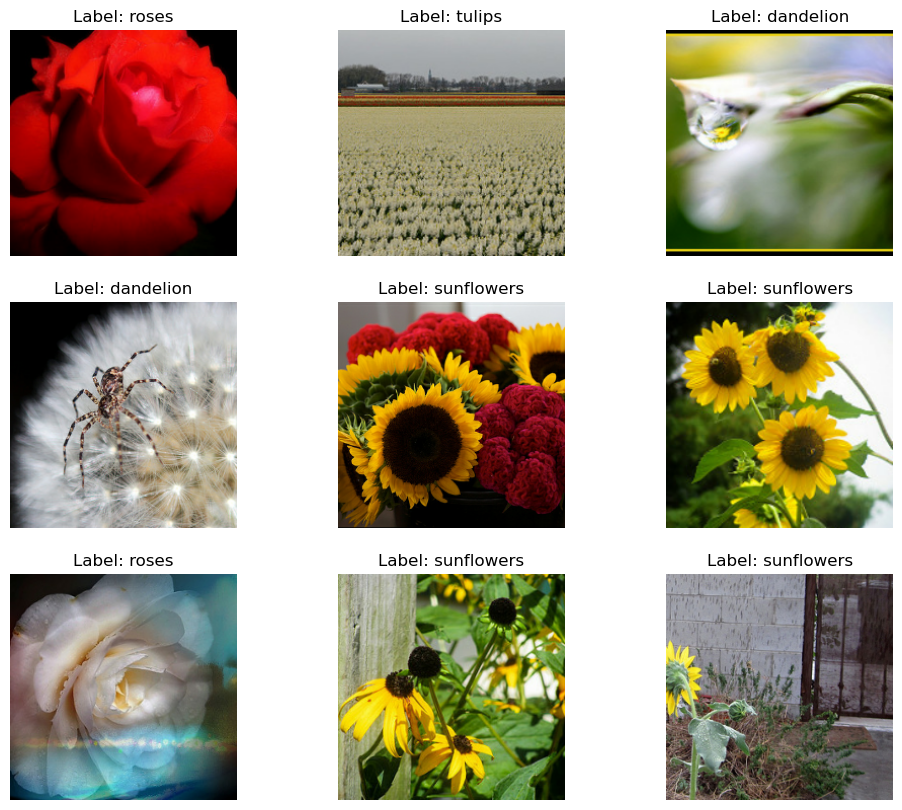

In [21]:
show_dataset_images(validation_dataset)

In [22]:
test_dataset = transform_images(test_images, test_labels)

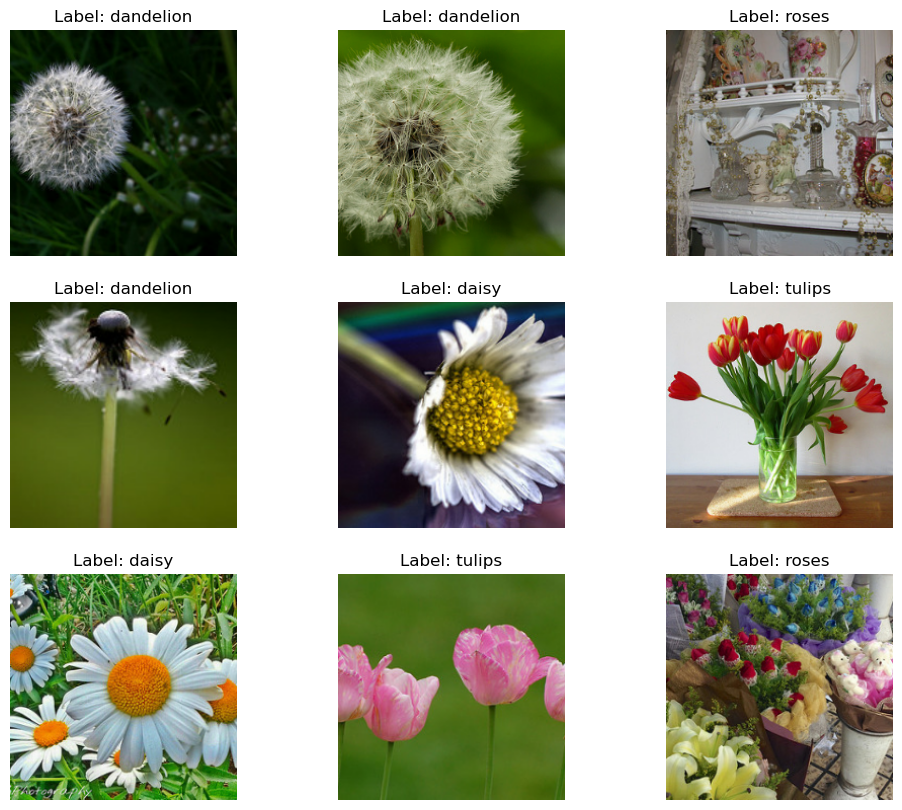

In [23]:
show_dataset_images(test_dataset)

### Batching

In [25]:
batch_size = 16

In [26]:
# shuffling the data set to ensure training model does not learn any unintended patterns due to the order of the data
# Prefetching improves the efficiency of data loading by overlapping the data preprocessing and model training.
train_set = train_dataset.shuffle(1000, seed=42).batch(batch_size).prefetch(1)

In [27]:
valid_set = validation_dataset.batch(batch_size)
test_set = test_dataset.batch(batch_size)

## Loading Xception Model

In [28]:
# Ensure reproducibility
tf.random.set_seed(42)

# Load the Xception model, excluding the top layers
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)

# Add a global average pooling layer
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)

# Define the number of classes for the flower dataset
n_classes = len(classes)

# Add the output layer relevant to this dataset
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)

# Create the new model
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


Experiments show adding fully connected layers showed poorer performance. Hence, in the current iteration, these are ignored.

In [29]:
# print the model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, None, None, 3)     │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, None, None, 32)    │             864 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_bn               │ (None, None, None, 32)    │             128 │ block1_conv1[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1_act (Activation) │ (None, None, None, 32)    │               0 │ block1_conv1_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, None, None, 64)    │          18,432 │ block1_conv1_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_bn               │ (None, None, None, 64)    │             256 │ block1_conv2[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2_act (Activation) │ (None, None, None, 64)    │               0 │ block1_conv2_bn[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1               │ (None, None, None, 128)   │           8,768 │ block1_conv2_act[0][0]     │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv1_bn            │ (None, None, None, 128)   │             512 │ block2_sepconv1[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_act           │ (None, None, None, 128)   │               0 │ block2_sepconv1_bn[0][0]   │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2               │ (None, None, None, 128)   │          17,536 │ block2_sepconv2_act[0][0]  │
│ (SeparableConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_sepconv2_bn            │ (None, None, None, 128)   │             512 │ block2_sepconv2[0][0]      │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, None, None, 128)   │           8,192 │ block1_conv2_act[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, None, None, 128)   │               

 Total params: 20,871,725 (79.62 MB)

 Trainable params: 20,817,197 (79.41 MB)

 Non-trainable params: 54,528 (213.00 KB)

## Model1: Freeze the weights for all layers of pretrain model

In [30]:
for layer in base_model.layers:
    layer.trainable = False

In [31]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 120s 754ms/step - accuracy: 0.7186 - loss: 1.2061 - val_accuracy: 0.8682 - val_loss: 0.9184
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 120s 768ms/step - accuracy: 0.9050 - loss: 0.4934 - val_accuracy: 0.8727 - val_loss: 0.8607
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 122s 780ms/step - accuracy: 0.9300 - loss: 0.3507 - val_accuracy: 0.8250 - val_loss: 1.3303
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 117s 750ms/step - accuracy: 0.9375 - loss: 0.2557 - val_accuracy: 0.8841 - val_loss: 0.8544
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 117s 752ms/step - accuracy: 0.9554 - loss: 0.1910 - val_accuracy: 0.8636 - val_loss: 0.9754


In [32]:
def show_loss_accuracy(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plotting the loss and accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the loss
    ax1.plot(train_loss, label='Training Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_title('Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot the accuracy
    ax2.plot(train_accuracy, label='Training Accuracy')
    ax2.plot(val_accuracy, label='Validation Accuracy')
    ax2.set_title('Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

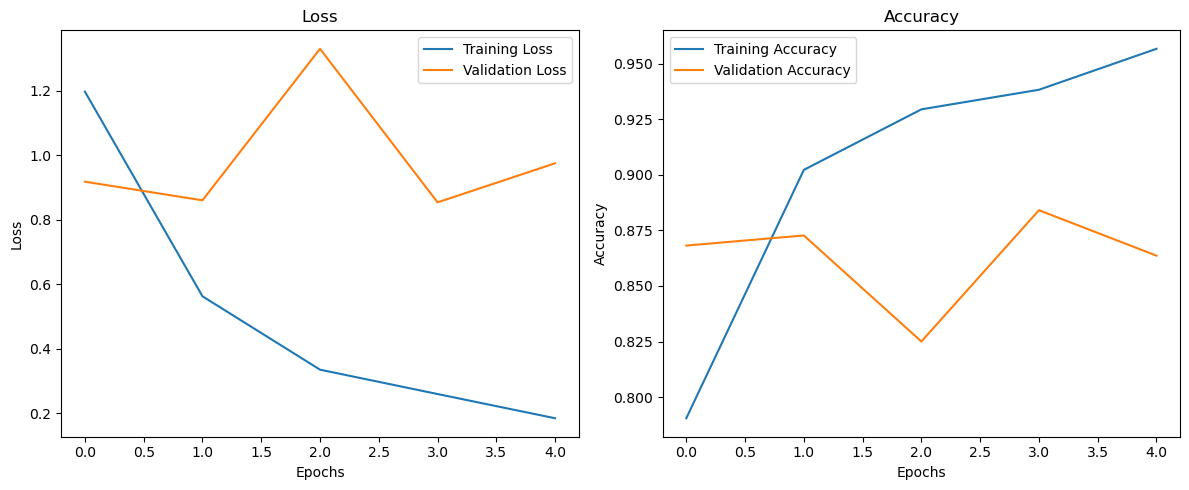

In [33]:
show_loss_accuracy(history)

## Exam the Xception model architecture

In [34]:
# number of layers in Xcception mode
num_layers = len(base_model.layers)
print(f"Number of layers in model: {num_layers}")

Number of layers in model: 132


In [35]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_layer_1          33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

## Model2: unfreeze layer 56 and above

In [36]:
unfreeze_layer = 56
# unfreeze layer at unfreeze_layer and above
for layer in model.layers[unfreeze_layer:]:
    layer.trainable = True

In [38]:
# recompile model and train for another 10 epochs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.9957 - loss: 0.0269 - val_accuracy: 0.9455 - val_loss: 0.1885
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.9964 - loss: 0.0147 - val_accuracy: 0.9477 - val_loss: 0.2170
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.9919 - loss: 0.0245 - val_accuracy: 0.9318 - val_loss: 0.2227
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.9964 - loss: 0.0129 - val_accuracy: 0.9455 - val_loss: 0.2061
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 327s 2s/step - accuracy: 0.9981 - loss: 0.0076 - val_accuracy: 0.9500 - val_loss: 0.1885


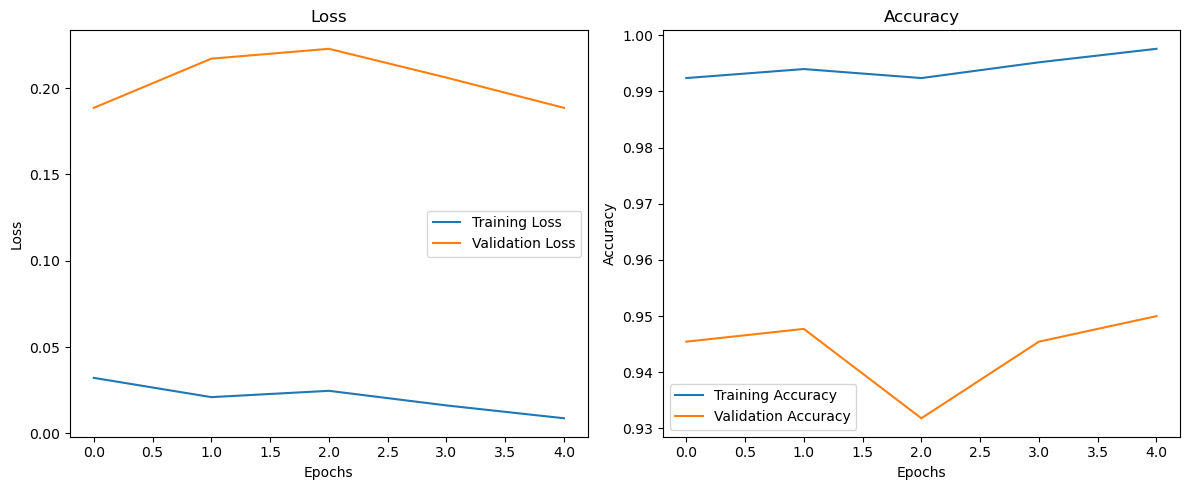

In [39]:
show_loss_accuracy(history)

In [64]:
from sklearn.metrics import classification_report,confusion_matrix

def show_predictions(model):
    pred_probabilities = model.predict(test_set)
    predictions = np.argmax(pred_probabilities, axis=1)
    predictions_str = [class_names[index] for index in predictions]
    print(classification_report(test_labels, predictions_str))

In [65]:
show_predictions(model)

46/46 ━━━━━━━━━━━━━━━━━━━━ 29s 640ms/step
              precision    recall  f1-score   support

       daisy       0.91      0.95      0.93       127
   dandelion       0.96      0.96      0.96       179
       roses       0.88      0.93      0.90       128
  sunflowers       0.99      0.96      0.97       140
      tulips       0.93      0.88      0.91       160

    accuracy                           0.94       734
   macro avg       0.93      0.94      0.94       734
weighted avg       0.94      0.94      0.94       734



## Model3: unfreeze all layers

In [66]:
unfreeze_layer = 0
# unfreeze layer at unfreeze_layer and above
for layer in model.layers[unfreeze_layer:]:
    layer.trainable = True

In [67]:
# recompile model and train for another 10 epochs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 653s 4s/step - accuracy: 0.9808 - loss: 0.0634 - val_accuracy: 0.9114 - val_loss: 0.3181
Epoch 2/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 639s 4s/step - accuracy: 0.9887 - loss: 0.0365 - val_accuracy: 0.9114 - val_loss: 0.2851
Epoch 3/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 652s 4s/step - accuracy: 0.9790 - loss: 0.0646 - val_accuracy: 0.9409 - val_loss: 0.2639
Epoch 4/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 662s 4s/step - accuracy: 0.9887 - loss: 0.0294 - val_accuracy: 0.9545 - val_loss: 0.2035
Epoch 5/5
156/156 ━━━━━━━━━━━━━━━━━━━━ 644s 4s/step - accuracy: 0.9938 - loss: 0.0190 - val_accuracy: 0.9523 - val_loss: 0.1897


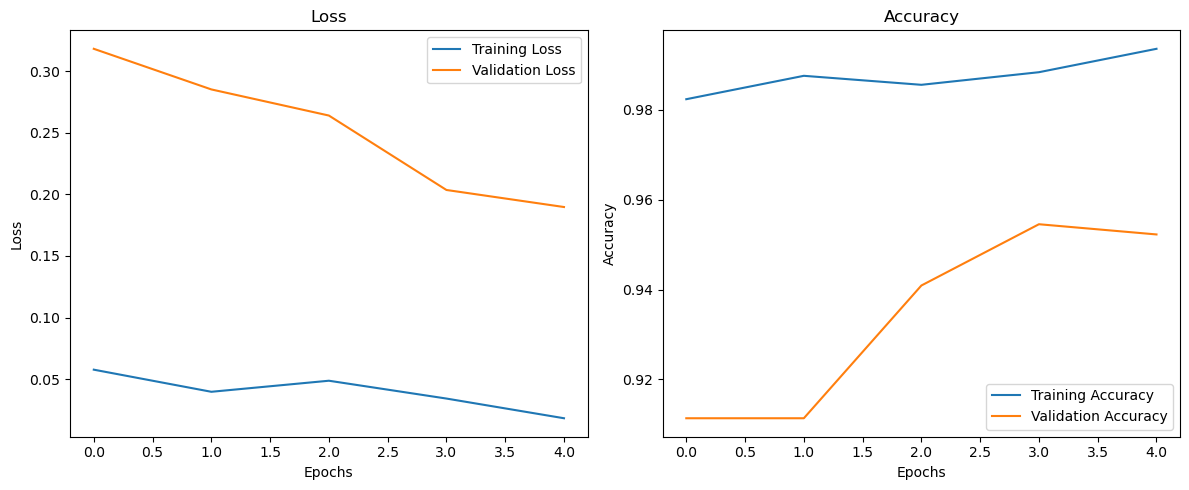

In [68]:
show_loss_accuracy(history)

In [69]:
show_predictions(model)

46/46 ━━━━━━━━━━━━━━━━━━━━ 33s 709ms/step
              precision    recall  f1-score   support

       daisy       0.96      0.93      0.94       127
   dandelion       0.93      0.97      0.95       179
       roses       0.82      0.91      0.87       128
  sunflowers       0.98      0.94      0.96       140
      tulips       0.91      0.84      0.87       160

    accuracy                           0.92       734
   macro avg       0.92      0.92      0.92       734
weighted avg       0.92      0.92      0.92       734

